In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy.table import Table

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from sst1mpipe.io import load_config
from sst1mpipe.performance import get_theta

from sst1mpipe.io import load_photon_list_sst1m

from sst1mpipe.analysis import (
    plot_theta2,
    add_wobble_flag,
    get_theta_off,
    get_sigma_time,
    plot_sigma_time,
    plot_count_maps,
    plot_mc_data,
    add_source_xy,
    add_source_altaz,
    get_camera_frame
)

from sst1mpipe.utils import get_horizon_frame

In [2]:
import matplotlib as mpl
font = {'size'   : 25,
       'family': 'DejaVu Sans'}

mpl.rc('font', **font)
plt.rc('legend',fontsize=15)

In [3]:
def load_data(files, config=None, tel=None):
    i = 0
    
    for input_file in files:
        #print(input_file)
        try:
            df = load_photon_list_sst1m(input_file, tel=tel, config=config, table='pandas', energy_min=0.0)
        except:
            print("No such node", input_file)
            continue
        if i == 0:
            dl3_data = df
        else:
            try:
                dl3_data = pd.concat([dl3_data, df])
            except:
                print("Broken file", input_file)
        i += 1
    return dl3_data
        

In [4]:
def make_file_list(dates, data_path, wobble=''):
    
    files_selected = []
    
    for date in dates:
        files = glob.glob(data_path + "*" + str(date) + '*' + wobble + '*h5')

        files_selected = files_selected + files
    
    files_selected = np.sort(files_selected)
    return files_selected

# Input photon list path

In [5]:
data_path = '/mnt/nfs22_auger/jurysek/sst1m_data/cs1/dl2_sst1mpipe_crab/RFs_40deg_psf_vaod0.2/photon_lists/'

# Config file

In [6]:
config_file = '/home/jurysek/sst1mpipe_workdir/cfg/sst1mpipe_data_config_analysis.json'
config = load_config(config_file)

In [7]:
# Poiting coords
pointing_w1 = SkyCoord(ra=84.38609814 * u.deg, dec=21.95575128 * u.deg, frame='icrs')
pointing_w2 = SkyCoord(ra=82.88140425 * u.deg, dec=22.08341809 * u.deg, frame='icrs')
pointing_w1.info.name = 'W1'
pointing_w2.info.name = 'W2'

In [8]:
tel = 'tel_021'
wobble = ''

# Source

In [9]:
source = SkyCoord.from_name("Crab")

# Input files

In [10]:
# Dates
dates = np.array(
    [20230910, 20230915, 20230917]
)

In [11]:
files_selected = make_file_list(dates, data_path, wobble=wobble)

In [12]:
len(files_selected)

245

# Loading the data

In [13]:
photon_list = load_data(files_selected, config=config, tel=tel)

# cut on zenith angle

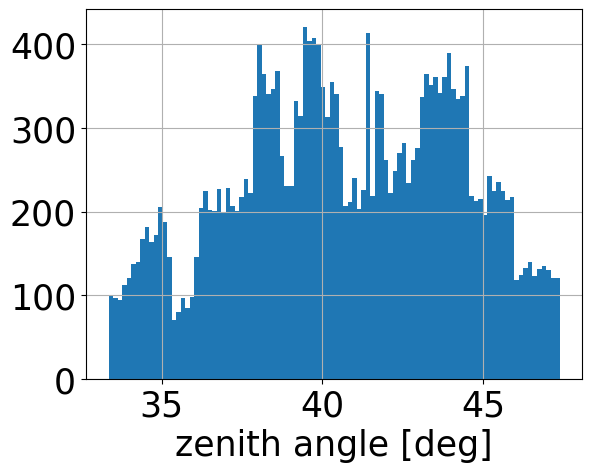

In [14]:
plt.figure()
h=plt.hist(90-photon_list.true_alt_tel, bins=100)
plt.xlabel('zenith angle [deg]')
plt.grid()

In [15]:
min_zenith = 20
max_zenith = 60
zenith_mask = (photon_list.true_alt_tel > 90.-max_zenith) & (photon_list.true_alt_tel <= 90.-min_zenith)

In [16]:
# elapsed time: sum of those time differences, excluding large ones
time_diff = photon_list[zenith_mask]['local_time'].diff()
t_elapsed = np.sum(time_diff[time_diff < 10. * u.s]) * u.s

In [17]:
print('Integration time (after cleaning and cuts):', t_elapsed.to(u.hour))

Integration time (after cleaning and cuts): 3.6514156277312173 h


# Cuts on reco energy

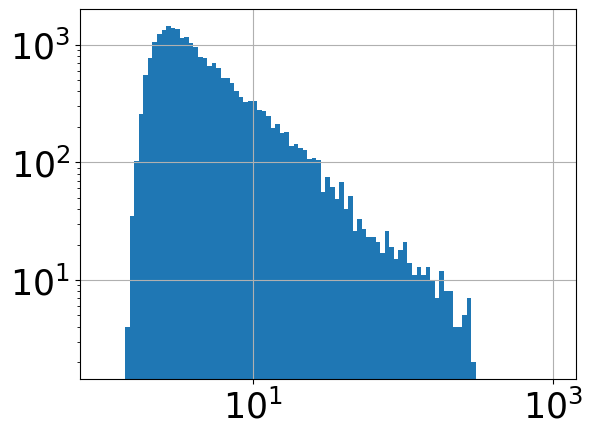

In [18]:
h2 = plt.hist(photon_list.reco_energy, bins=np.logspace(0, 3, 100))
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [19]:
energy_mask = (photon_list.reco_energy > 1.0) & (photon_list.reco_energy < 500)

In [20]:
dl3_photon_list = photon_list[energy_mask & zenith_mask]

In [21]:
len(dl3_photon_list)

23795

# Adding source position in the data

In [22]:
camera_frame = get_camera_frame(dl3_photon_list, config=config, telescope=tel)

Focal length used:  5.6 m


In [23]:
horizon_frame = get_horizon_frame(config=config, telescope=tel, times=Time(dl3_photon_list.local_time, format='unix'))

In [24]:
# adding altitude and azimuth of the source position to each event
dl3_photon_list = add_source_altaz(dl3_photon_list, source=source, horizon_frame=horizon_frame)

In [25]:
# coordinates of the source in camera frame
dl3_photon_list = add_source_xy(dl3_photon_list, source=source, camera_frame=camera_frame)

        Use @ instead. [ctapipe.coordinates.telescope_frame]
        Use @ instead.


# Theta2 plot

In [26]:
# theta for ON coordinates directly at the position of the source
dl3_photon_list_table = get_theta(
    Table.from_pandas(dl3_photon_list), 
    zero_alt=Table.from_pandas(dl3_photon_list)["source_alt"], 
    zero_az=Table.from_pandas(dl3_photon_list)["source_az"]
)
dl3_photon_list_table['theta'] = dl3_photon_list_table['theta'].to(u.deg)

In [27]:
# Adding wobble flag
dl3_photon_list_table = add_wobble_flag(dl3_photon_list_table, horizon_frame=horizon_frame, wobbles=[pointing_w1, pointing_w2])

        Use @ instead. [ctapipe.coordinates.telescope_frame]
        Use @ instead.


(23795, 1)
(23795, 2)
(23795, 3)
(23795, 4)
(23795, 5)
(23795, 6)


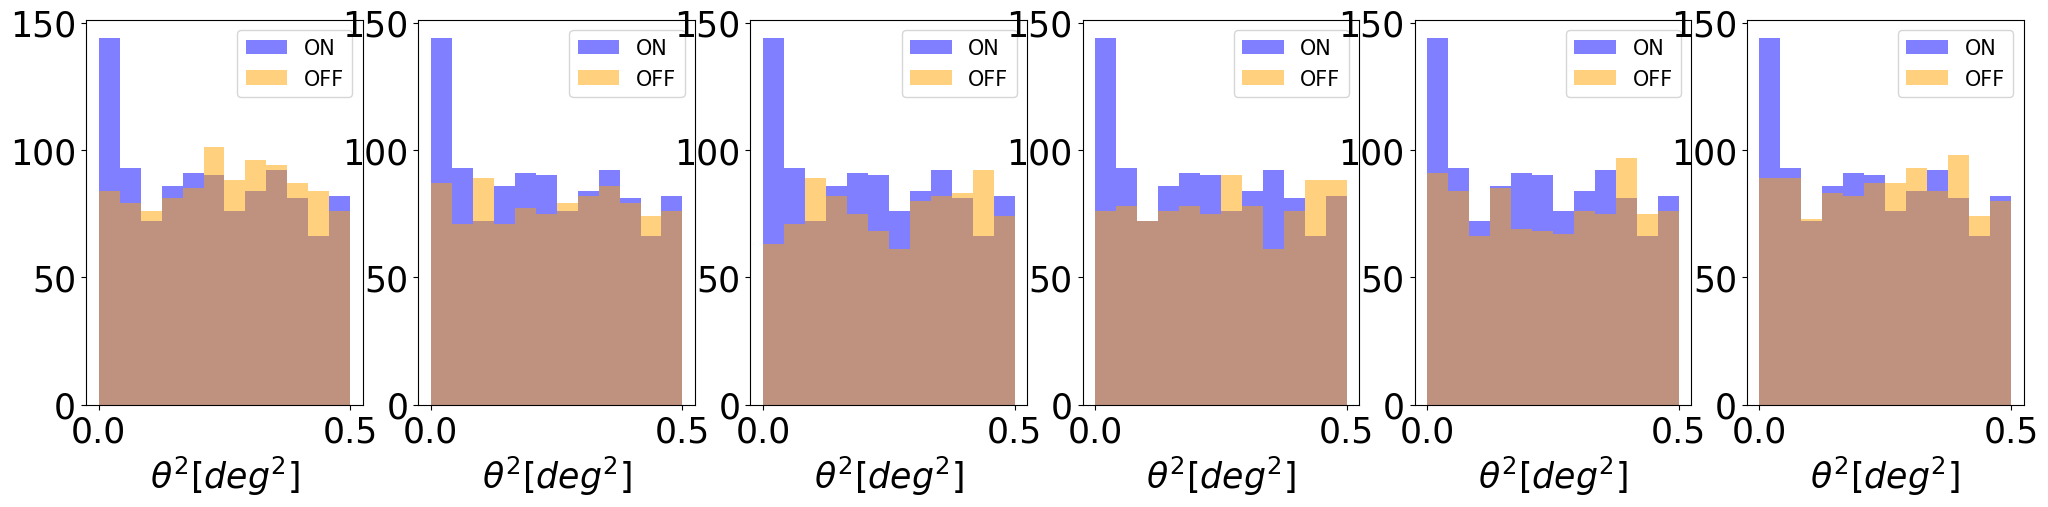

In [28]:
# calculate thetas for several off regions
theta2_off, off_radec_w = get_theta_off(dl3_photon_list_table, 
                                        n_off=config['analysis']['off_regions'], 
                                        horizon_frame=horizon_frame, 
                                        camera_frame=camera_frame,
                                        plot=True)

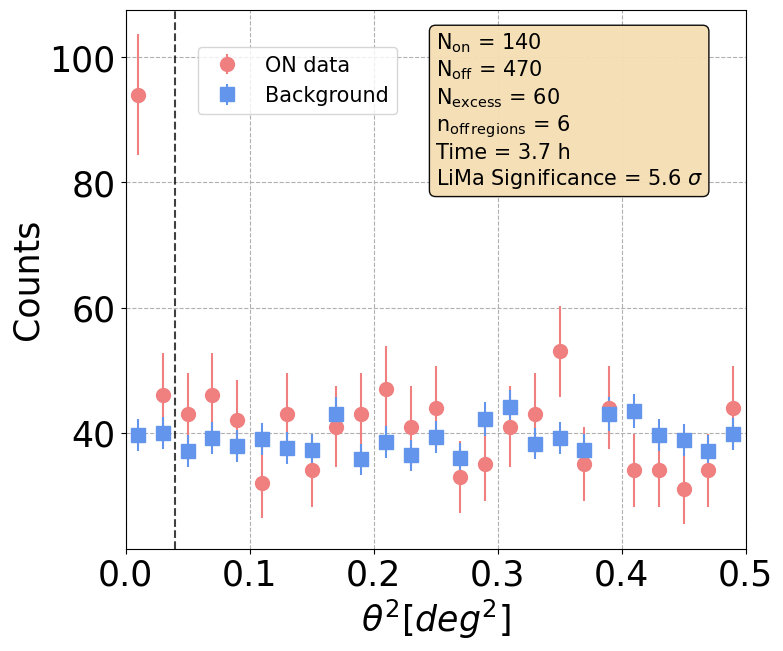

In [29]:
theta2_on = dl3_photon_list_table['theta']**2
plot_theta2(theta2_on, 
            theta2_off, 
            theta2_range=[0, 0.5], 
            n_bins_before_th2_cut=2, 
            theta2_cut=config['analysis']['global_theta_cut']**2, 
            norm_range=[0.2, 0.5], 
            t_elapsed=t_elapsed
           )

# Time development of significance

In [30]:
sigma, times, obsid, alphas = get_sigma_time(dl3_photon_list_table,
                                             theta2_on, 
                                             theta2_off,
                                             theta2_cut=config['analysis']['global_theta_cut']**2, 
                                             norm_range=[0.2, 0.5],
                                             step_events=50)

[20230910 20230915 20230917]


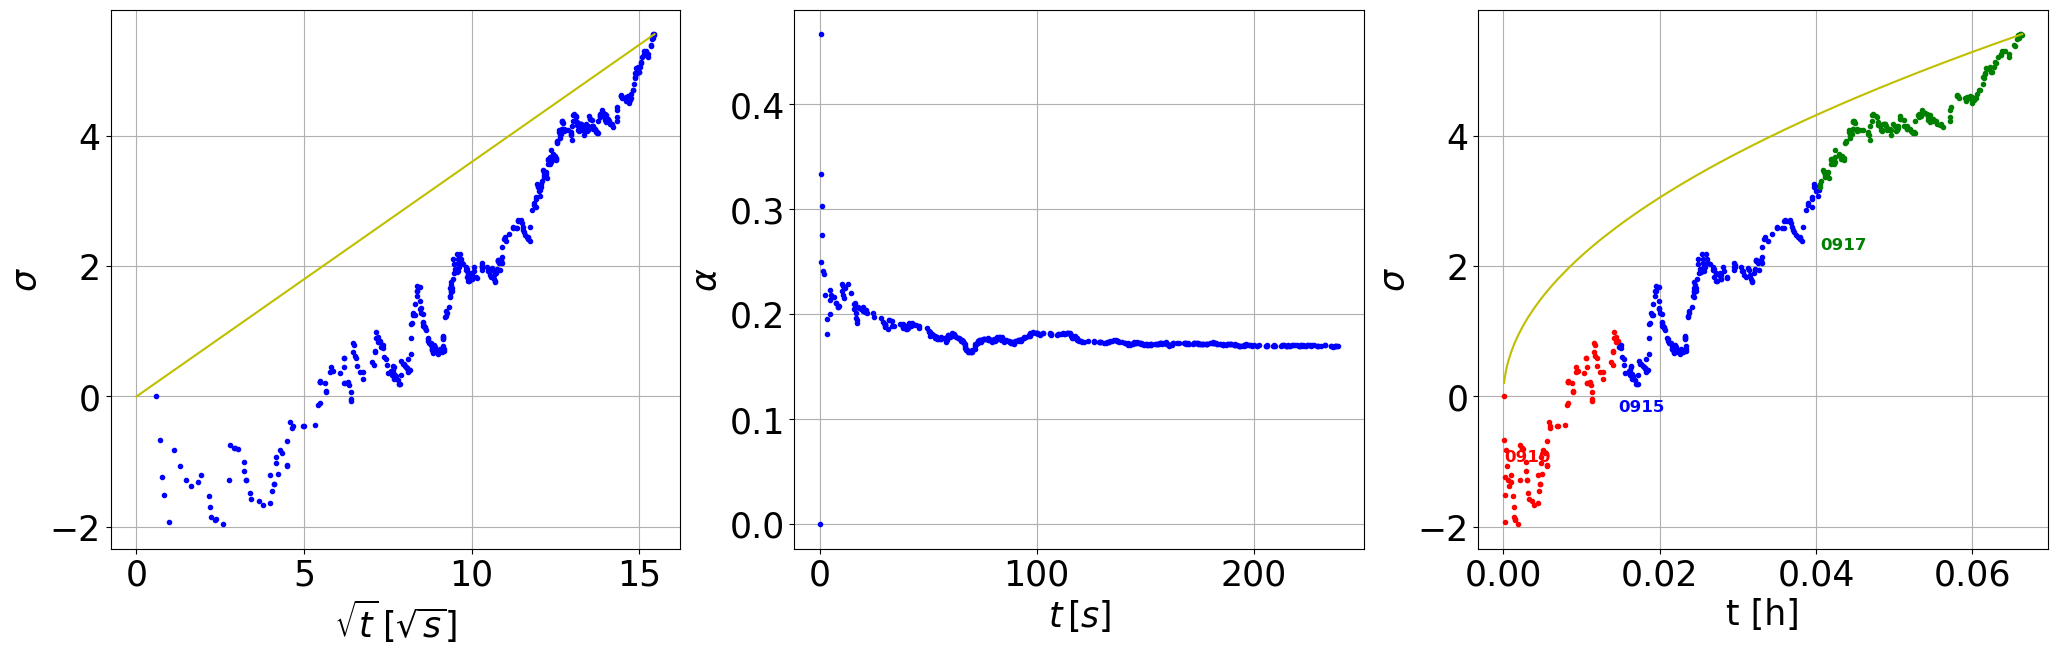

In [31]:
nights = np.unique(np.array(dl3_photon_list_table['date']))
print(nights)
nights_str = [str(x) for x in nights]
nights_str = [s + '0000' for s in nights_str]
nights = [int(x) for x in nights_str]
plot_sigma_time(dl3_photon_list_table, sigma, times, obsid, alphas, nights)

# 2D count maps

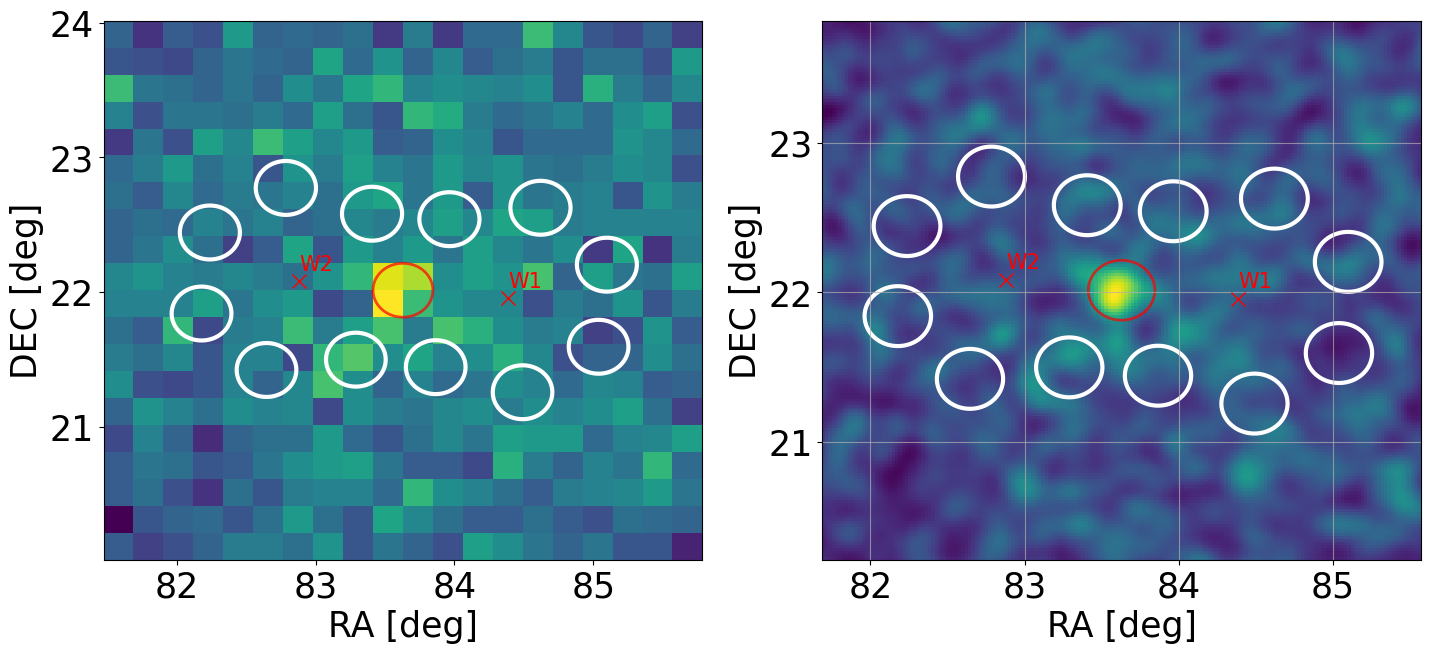

In [33]:
plot_count_maps(dl3_photon_list,
                bins_raw=20, 
                bins_conv=200,
                conv_kernel_deg=0.07,
                range_deg=4, 
                source=source,
                theta2_cut=config['analysis']['global_theta_cut']**2, 
                wobbles=[pointing_w1, pointing_w2],
                off_radec_w=off_radec_w
               )